## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
from fastai.conv_learner import *

In [4]:
PATH = "/data/dogscats/"
sz=299
arch=resnext50
bs=24

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [6]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                     
    0      0.068091   0.026498   0.9935    



In [7]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.037203   0.020646   0.9935    
    1      0.043837   0.019526   0.995                        



[0.019525613041056204, 0.9949999976158143]

In [8]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [9]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049077   0.017681   0.993     
    1      0.056947   0.017465   0.994                        
    2      0.024978   0.015355   0.9945                       



[0.015354968488536543, 0.9944999973773956]

In [10]:
learn.save('224_all_50')

In [11]:
learn.load('224_all_50')

In [13]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9965

## Analyzing results

In [14]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  3 997]]


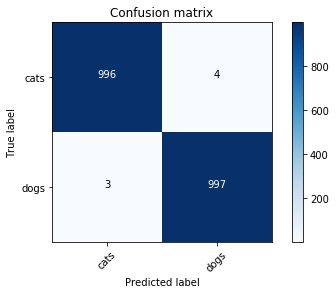

In [15]:
plot_confusion_matrix(cm, data.classes)

In [16]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


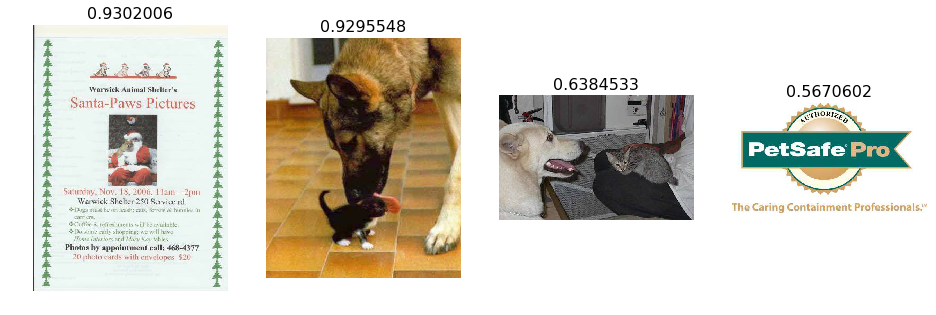

In [17]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


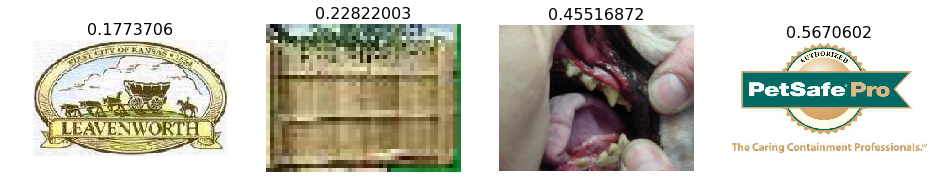

In [18]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")